# Fair AI with COMPAS Dataset

## 1. Setup

### 1.1 Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import chi2_contingency, fisher_exact

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

### 1.2 Utility Functions

In [2]:
results_dir = "../results"
def save_plot(filename):
    """
    Save a plot to the results directory.

    Args:
        filename (str): The name of the file to save the plot as.
    """
    filepath = os.path.join(results_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')

## 2. Data Loading

### 2.1 Raw Dataets

#### 2.1.1 COMPAS scores raw

In [3]:
# compas scores raw
df_compas = pd.read_csv("../data/compas-scores-raw.csv")
print(f"Shape compas-scores-raw: {df_compas.shape}")
print(f"Columns: {df_compas.columns.tolist()}")
df_compas.head()

Shape compas-scores-raw: (60843, 28)
Columns: ['Person_ID', 'AssessmentID', 'Case_ID', 'Agency_Text', 'LastName', 'FirstName', 'MiddleName', 'Sex_Code_Text', 'Ethnic_Code_Text', 'DateOfBirth', 'ScaleSet_ID', 'ScaleSet', 'AssessmentReason', 'Language', 'LegalStatus', 'CustodyStatus', 'MaritalStatus', 'Screening_Date', 'RecSupervisionLevel', 'RecSupervisionLevelText', 'Scale_ID', 'DisplayText', 'RawScore', 'DecileScore', 'ScoreText', 'AssessmentType', 'IsCompleted', 'IsDeleted']


,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,...,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0


#### 2.1.2 Cox Violent Parsed Dataset

In [4]:
# Cox Violent Parsed Dataset
df_cox = pd.read_csv("../data/cox-violent-parsed.csv")
print(f"Shape cox-violent-parsed: {df_cox.shape}")
print(f"Columns: {df_cox.columns.tolist()}")
df_cox.head()

Shape cox-violent-parsed: (18316, 52)
Columns: ['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob', 'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number', 'c_offense_date', 'c_arrest_date', 'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number', 'r_charge_degree', 'r_days_from_arrest', 'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid', 'is_violent_recid', 'vr_case_number', 'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc', 'type_of_assessment', 'decile_score.1', 'score_text', 'screening_date', 'v_type_of_assessment', 'v_decile_score', 'v_score_text', 'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1', 'start', 'end', 'event']


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event
0,1.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,...,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,0,327,0
1,2.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,...,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,334,961,0
2,3.0,michael ryan,michael,ryan,31/12/2014,Male,06/02/1985,31,25 - 45,Caucasian,...,Risk of Violence,2,Low,31/12/2014,30/12/2014,03/01/2015,0,3,457,0
3,4.0,kevon dixon,kevon,dixon,27/01/2013,Male,22/01/1982,34,25 - 45,African-American,...,Risk of Violence,1,Low,27/01/2013,26/01/2013,05/02/2013,0,9,159,1
4,5.0,ed philo,ed,philo,14/04/2013,Male,14/05/1991,24,Less than 25,African-American,...,Risk of Violence,3,Low,14/04/2013,16/06/2013,16/06/2013,4,0,63,0


#### 2.1.3 Cox Violent Parsed Filtered Dataset

In [5]:
# Cox Violent Parsed Filtered Dataset
df_cox_filt = pd.read_csv("../data/cox-violent-parsed_filt.csv")
print(f"Shape cox-violent-parsed_filt: {df_cox_filt.shape}")
print(f"Columns: {df_cox_filt.columns.tolist()}")
df_cox_filt.head()

Shape cox-violent-parsed_filt: (18316, 40)
Columns: ['id', 'name', 'first', 'last', 'sex', 'dob', 'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_charge_degree', 'r_days_from_arrest', 'r_offense_date', 'r_charge_desc', 'r_jail_in', 'violent_recid', 'is_violent_recid', 'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc', 'type_of_assessment', 'decile_score.1', 'score_text', 'screening_date', 'v_type_of_assessment', 'v_decile_score', 'v_score_text', 'priors_count.1', 'event']


,id,name,first,last,sex,dob,age,age_cat,race,juv_fel_count,...,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,priors_count.1,event
0,1.0,miguel hernandez,miguel,hernandez,Male,18/04/1947,69,Greater than 45,Other,0,...,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,0,0
1,2.0,miguel hernandez,miguel,hernandez,Male,18/04/1947,69,Greater than 45,Other,0,...,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,0,0
2,3.0,michael ryan,michael,ryan,Male,06/02/1985,31,25 - 45,Caucasian,0,...,NaN,Risk of Recidivism,5,Medium,31/12/2014,Risk of Violence,2,Low,0,0
3,4.0,kevon dixon,kevon,dixon,Male,22/01/1982,34,25 - 45,African-American,0,...,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,27/01/2013,Risk of Violence,1,Low,0,1
4,5.0,ed philo,ed,philo,Male,14/05/1991,24,Less than 25,African-American,0,...,NaN,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low,4,0


#### 2.1.4 ProPublica data

In [6]:
# propublica data
df_propublica = pd.read_csv("../data/propublica_data_for_fairml.csv")
print(f"Shape propublica_data_for_fairml: {df_propublica.shape}")
print(f"Columns: {df_propublica.columns.tolist()}")
df_propublica.head()

Shape propublica_data_for_fairml: (6172, 12)
Columns: ['Two_yr_Recidivism', 'Number_of_Priors', 'score_factor', 'Age_Above_FourtyFive', 'Age_Below_TwentyFive', 'African_American', 'Asian', 'Hispanic', 'Native_American', 'Other', 'Female', 'Misdemeanor']


,Two_yr_Recidivism,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor
0,0,0,0,1,0,0,0,0,0,1,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0
2,1,4,0,0,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,1
4,1,14,1,0,0,0,0,0,0,0,0,0


### 2.2 Dataset Comparison

In [7]:
# Matched Columns between datasets
print("Matched Columns:")
compas_cols = set(df_compas.columns)
cox_cols = set(df_cox.columns)
cox_filt_cols = set(df_cox_filt.columns)
propublica_cols = set(df_propublica.columns)

print(f" - COMPAS y Cox: {compas_cols.intersection(cox_cols)}")
print(f" - Cox y Cox filtered: {cox_cols.intersection(cox_filt_cols)}")
print(f" - ProPublica y Cox: {propublica_cols.intersection(cox_cols)}")

Matched Columns:
 - COMPAS y Cox: set()
 - Cox y Cox filtered: {'type_of_assessment', 'c_jail_out', 'priors_count', 'race', 'days_b_screening_arrest', 'r_charge_desc', 'id', 'last', 'vr_charge_desc', 'v_score_text', 'v_decile_score', 'r_charge_degree', 'r_jail_in', 'event', 'screening_date', 'c_jail_in', 'juv_fel_count', 'juv_other_count', 'violent_recid', 'name', 'is_violent_recid', 'priors_count.1', 'juv_misd_count', 'decile_score.1', 'age_cat', 'c_days_from_compas', 'is_recid', 'score_text', 'c_charge_desc', 'c_charge_degree', 'age', 'r_days_from_arrest', 'first', 'dob', 'decile_score', 'sex', 'r_offense_date', 'vr_charge_degree', 'vr_offense_date', 'v_type_of_assessment'}
 - ProPublica y Cox: set()


## 3. Exploratory Data Analysis (EDA)
The best for EDA and fairness analysis is the ProPublica preprocessed dataset (`propublica_data_for_fairml.csv`) because it already highlights sensitive attributes (race, sex, age groups). Also, it’s smaller, cleaner, and directly highlights fairness issues.

In [8]:
df = pd.read_csv("../data/propublica_data_for_fairml.csv")

### 3.1 Dataset Overview

In [9]:
# Dataset info
print("\n--- Dataset Info ---")
print(df.info())

# Check for missing values
print("\n--- Missing Values ---")
print(df.isnull().sum())


--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6172 entries, 0 to 6171
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Two_yr_Recidivism     6172 non-null   int64
 1   Number_of_Priors      6172 non-null   int64
 2   score_factor          6172 non-null   int64
 3   Age_Above_FourtyFive  6172 non-null   int64
 4   Age_Below_TwentyFive  6172 non-null   int64
 5   African_American      6172 non-null   int64
 6   Asian                 6172 non-null   int64
 7   Hispanic              6172 non-null   int64
 8   Native_American       6172 non-null   int64
 9   Other                 6172 non-null   int64
 10  Female                6172 non-null   int64
 11  Misdemeanor           6172 non-null   int64
dtypes: int64(12)
memory usage: 578.8 KB
None

--- Missing Values ---
Two_yr_Recidivism       0
Number_of_Priors        0
score_factor            0
Age_Above_FourtyFive    0
Age_Below_T

### 3.2 Target Varible

--- Target Distribution ---
Two_yr_Recidivism
0    0.54488
1    0.45512
Name: proportion, dtype: float64


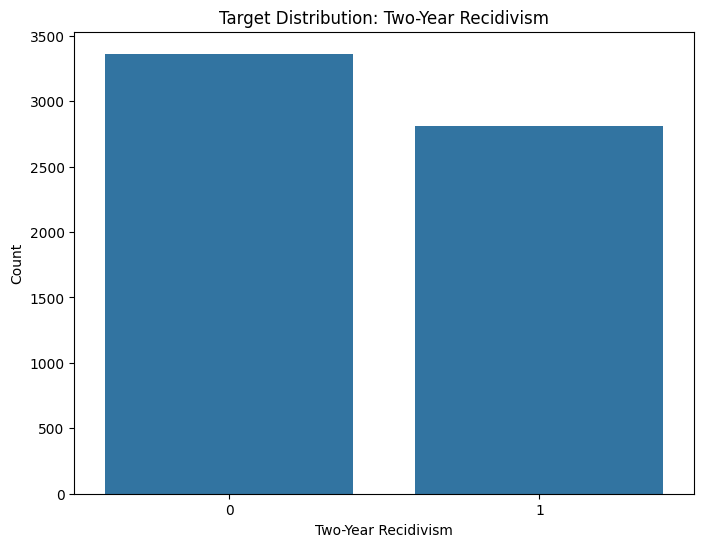

In [10]:
# Target: Two-year recidivism
print("--- Target Distribution ---")
print(df['Two_yr_Recidivism'].value_counts(normalize=True))

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="Two_yr_Recidivism")
plt.title("Target Distribution: Two-Year Recidivism")
plt.xlabel("Two-Year Recidivism")
plt.ylabel("Count")
save_plot("target_distribution.png")
plt.show()

### 3.3 Sensitive Attributes Distribution

#### 3.3.1 Race Distribution

--- Race Distribution ---
Race_Group
African_American    0.855152
Hispanic            0.082469
Other               0.055574
Asian               0.005023
Native_American     0.001782
Name: proportion, dtype: float64


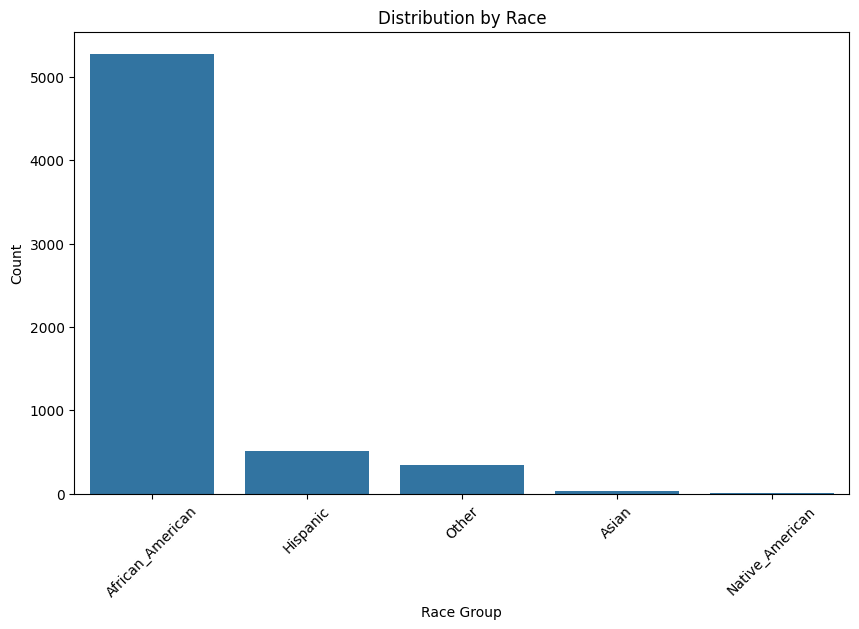

In [11]:
# Race distribution
race_cols = ['African_American', 'Asian', 'Hispanic', 'Native_American', 'Other']
df['Race_Group'] = df[race_cols].idxmax(axis=1)

print("--- Race Distribution ---")
print(df['Race_Group'].value_counts(normalize=True))

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="Race_Group", order=df['Race_Group'].value_counts().index)
plt.title("Distribution by Race")
plt.xlabel("Race Group")
plt.ylabel("Count")
plt.xticks(rotation=45)
save_plot("race_distribution.png")
plt.show()

#### 3.3.2 Gender Distribution

--- Gender Distribution ---
Female
0    0.809624
1    0.190376
Name: proportion, dtype: float64


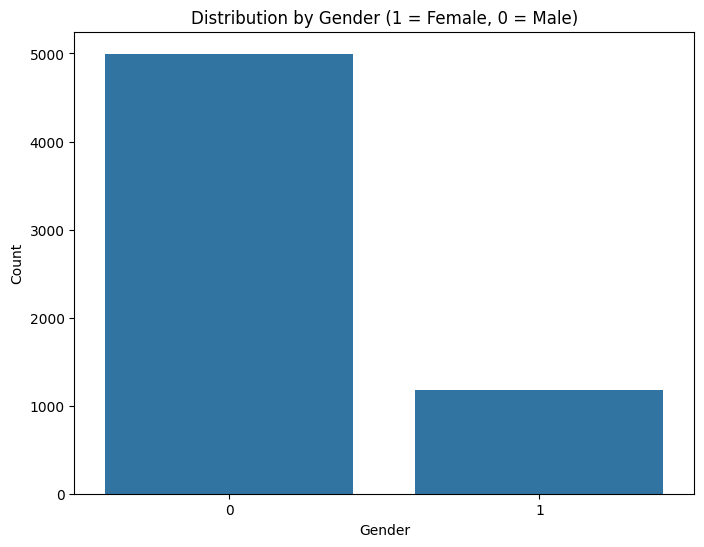

In [12]:
# Gender distribution
print("--- Gender Distribution ---")
print(df['Female'].value_counts(normalize=True))

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="Female")
plt.title("Distribution by Gender (1 = Female, 0 = Male)")
plt.xlabel("Gender")
plt.ylabel("Count")
save_plot("gender_distribution.png")
plt.show()

#### 3.3.3 Age Groups Distribution

--- Age Distribution ---
Age_Group
25-45       0.572262
Below 25    0.218244
Above 45    0.209494
Name: proportion, dtype: float64


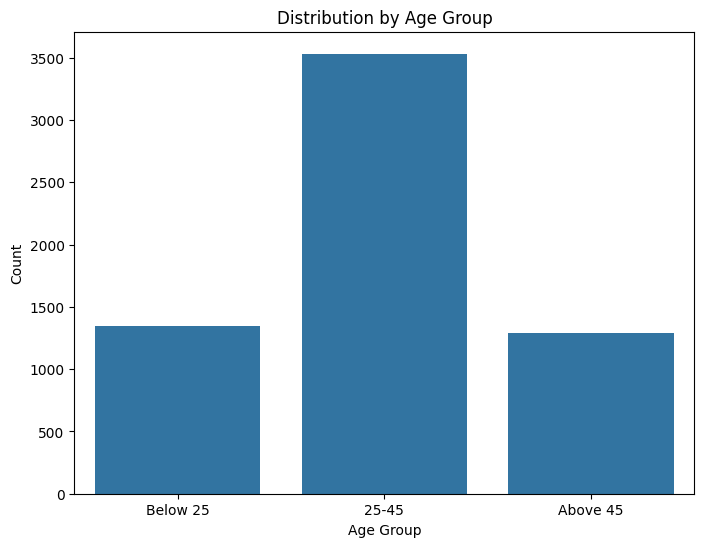

In [13]:
# Age groups
age_cols = ['Age_Above_FourtyFive', 'Age_Below_TwentyFive']
def get_age_group(row):
    """
    Get the age group for a given row.

    Args:
        row (pd.Series): A row from the DataFrame.

    Returns:
        str: The age group label.
    """
    if row['Age_Below_TwentyFive'] == 1:
        return 'Below 25'
    elif row['Age_Above_FourtyFive'] == 1:
        return 'Above 45'
    else:
        return '25-45'

df['Age_Group'] = df.apply(get_age_group, axis=1)

print("--- Age Distribution ---")
print(df['Age_Group'].value_counts(normalize=True))

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="Age_Group", order=['Below 25','25-45','Above 45'])
plt.title("Distribution by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Count")
save_plot("age_distribution.png")
plt.show()

### 3.4 Recividism by Group

#### 3.4.1 Recidivism by Race

--- Recidivism Rate by Race ---
 Race_Group
African_American    0.470443
Asian               0.258065
Hispanic            0.371316
Native_American     0.454545
Other               0.361516
Name: Two_yr_Recidivism, dtype: float64


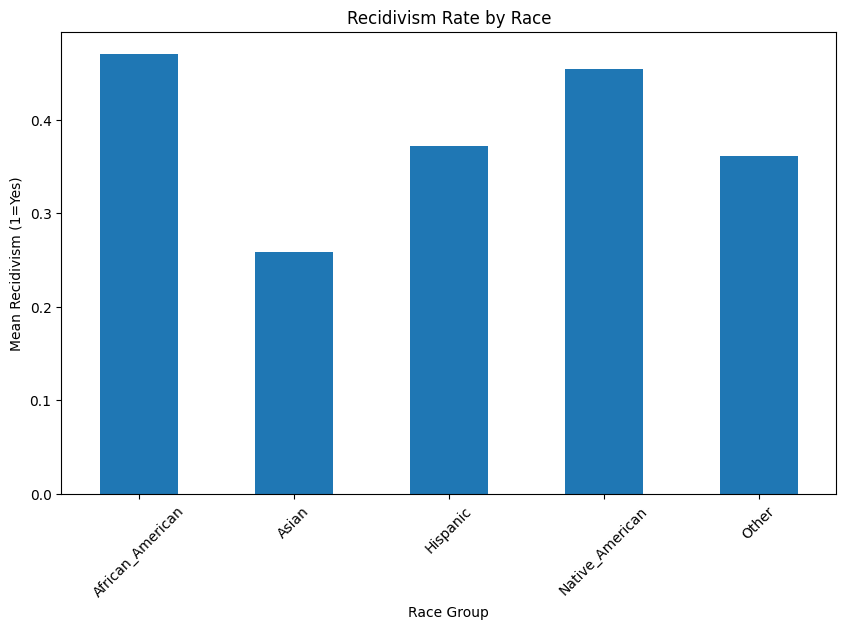

In [14]:
# Recidivism by Race
race_recid = df.groupby('Race_Group')['Two_yr_Recidivism'].mean()
print("--- Recidivism Rate by Race ---\n", race_recid)

plt.figure(figsize=(10, 6))
race_recid.plot(kind='bar')
plt.title("Recidivism Rate by Race")
plt.xlabel("Race Group")
plt.ylabel("Mean Recidivism (1=Yes)")
plt.xticks(rotation=45)
save_plot("recidivism_by_race.png")
plt.show()

#### 3.4.2 Recidivism by Gender

--- Recidivism Rate by Gender ---
 Female
0    0.479488
1    0.351489
Name: Two_yr_Recidivism, dtype: float64


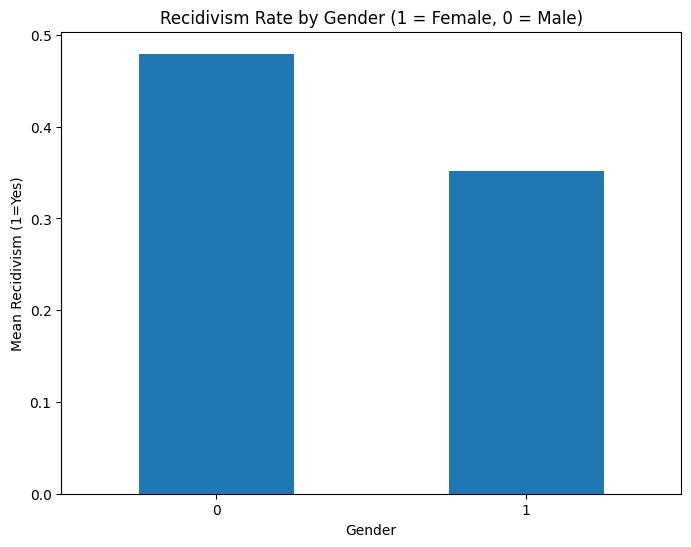

In [15]:
# Recidivism by Gender
gender_recid = df.groupby('Female')['Two_yr_Recidivism'].mean()
print("--- Recidivism Rate by Gender ---\n", gender_recid)

plt.figure(figsize=(8, 6))
gender_recid.plot(kind='bar')
plt.title("Recidivism Rate by Gender (1 = Female, 0 = Male)")
plt.xlabel("Gender")
plt.ylabel("Mean Recidivism (1=Yes)")
plt.xticks(rotation=0)
save_plot("recidivism_by_gender.png")
plt.show()

#### 3.4.3 Recidivism by Age Group

--- Recidivism Rate by Age Group ---
 Age_Group
25-45       0.464609
Above 45    0.320186
Below 25    0.559762
Name: Two_yr_Recidivism, dtype: float64


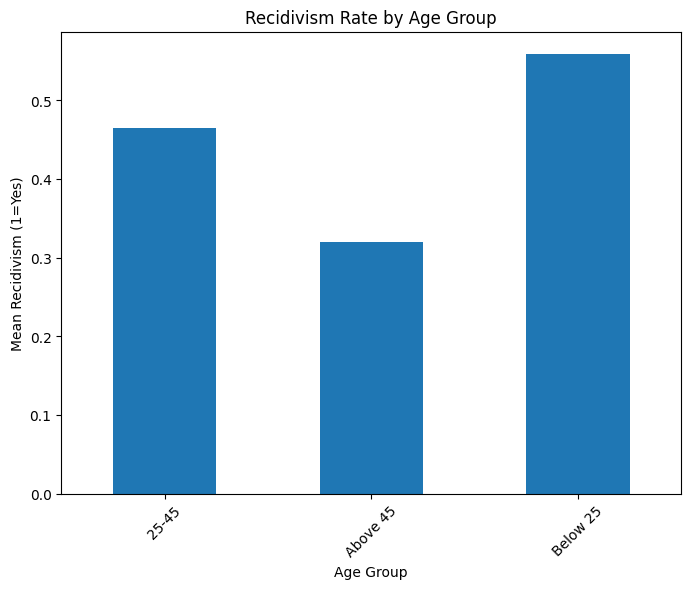

In [16]:
# Recidivism by Age Group
age_recid = df.groupby('Age_Group')['Two_yr_Recidivism'].mean()
print("--- Recidivism Rate by Age Group ---\n", age_recid)

plt.figure(figsize=(8, 6))
age_recid.plot(kind='bar')
plt.title("Recidivism Rate by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Mean Recidivism (1=Yes)")
plt.xticks(rotation=45)
save_plot("recidivism_by_age_group.png")
plt.show()

### 3.5 Number of Priors by Group

#### 3.5.1 Number of Priors by Race

--- Mean Number of Priors by Race ---
 Race_Group
African_American    3.461538
Asian               1.354839
Hispanic            2.100196
Native_American     5.181818
Other               1.746356
Name: Number_of_Priors, dtype: float64


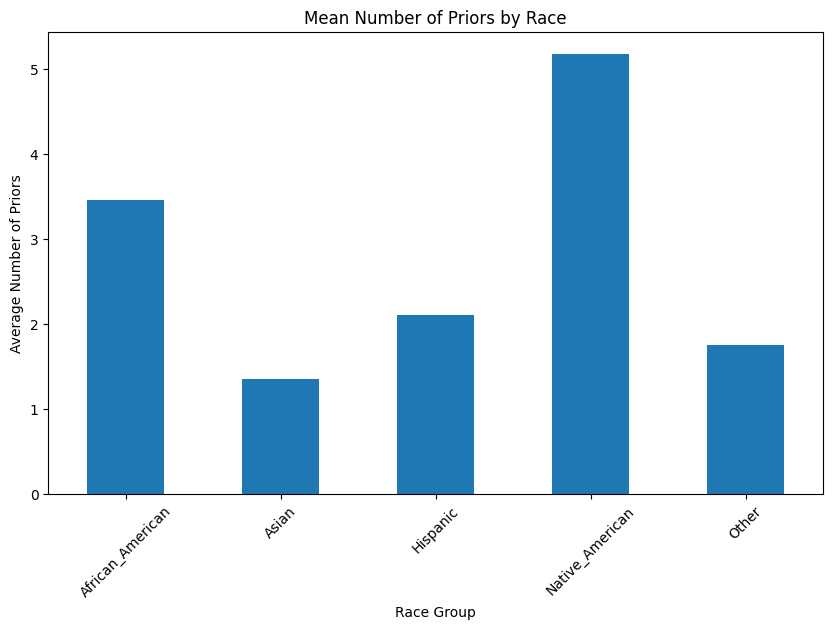

In [17]:
# Number_of_Priors by Race
priors_race = df.groupby('Race_Group')['Number_of_Priors'].mean()
print("--- Mean Number of Priors by Race ---\n", priors_race)

plt.figure(figsize=(10, 6))
priors_race.plot(kind='bar')
plt.title("Mean Number of Priors by Race")
plt.xlabel("Race Group")
plt.ylabel("Average Number of Priors")
plt.xticks(rotation=45)
save_plot("priors_by_race.png")
plt.show()

#### 3.5.2 Number of Priors by Gender

--- Mean Number of Priors by Gender ---
 Female
0    3.519512
1    2.085106
Name: Number_of_Priors, dtype: float64


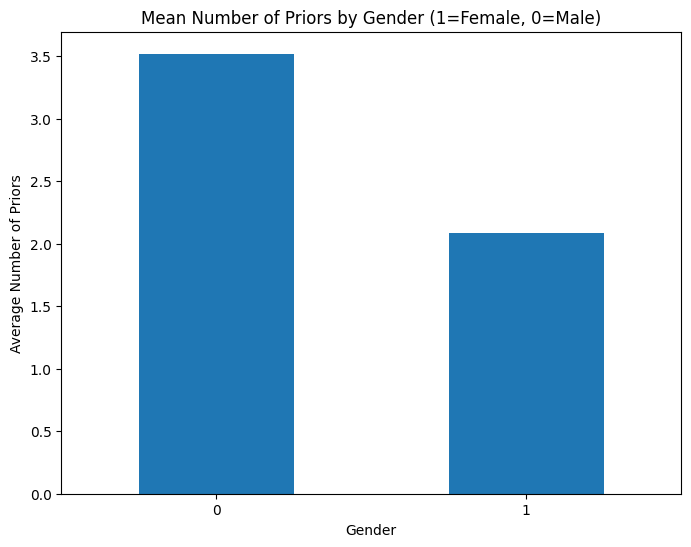

In [18]:
# Number_of_Priors by Gender
priors_gender = df.groupby('Female')['Number_of_Priors'].mean()
print("--- Mean Number of Priors by Gender ---\n", priors_gender)

plt.figure(figsize=(8, 6))
priors_gender.plot(kind='bar')
plt.title("Mean Number of Priors by Gender (1=Female, 0=Male)")
plt.xlabel("Gender")
plt.ylabel("Average Number of Priors")
plt.xticks(rotation=0)
save_plot("priors_by_gender.png")
plt.show()

#### 3.5.3 Number of Priors by African American Group

In [19]:
grouped = df.groupby(["Female", "African_American"])["Two_yr_Recidivism"].mean()
print(grouped)

Female  African_American
0       0                   0.395614
        1                   0.555217
1       0                   0.335463
        1                   0.369763
Name: Two_yr_Recidivism, dtype: float64


C:\Users\sarap\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


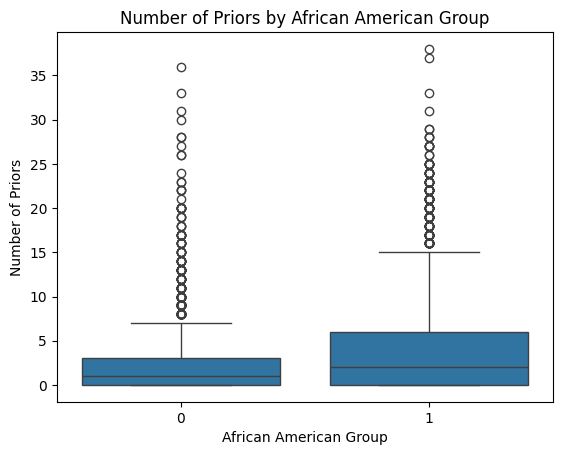

In [20]:
sns.boxplot(x="African_American", y="Number_of_Priors", data=df)
plt.title("Number of Priors by African American Group")
plt.xlabel("African American Group")
plt.ylabel("Number of Priors")
save_plot("priors_by_African_American.png")
plt.show()

### 3.6 Correlations & Statistical Tests

#### 3.6.1 Correlation Matrix

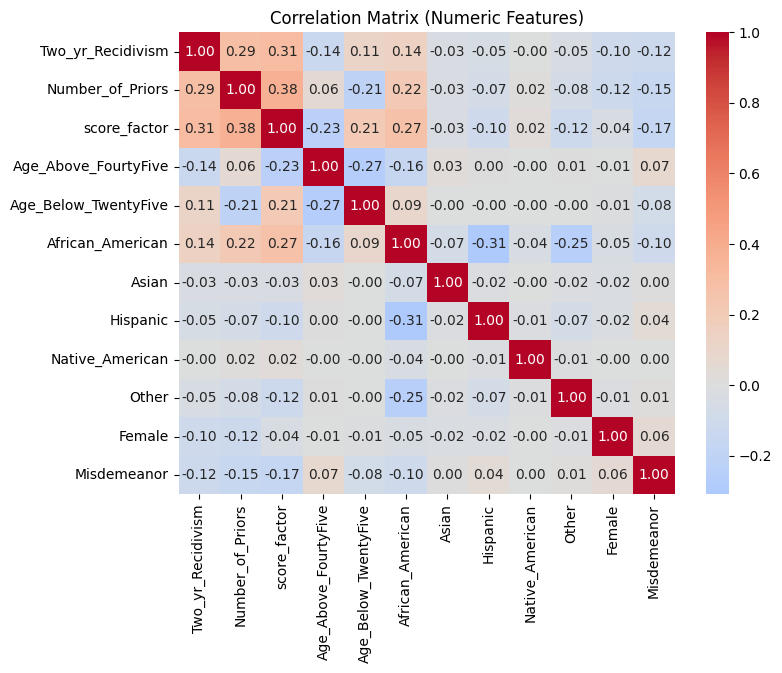

In [21]:
# Correlation Matrix - only numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

corr = df[numeric_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt='.2f')
plt.title("Correlation Matrix (Numeric Features)")
save_plot("correlation_matrix.png")
plt.show()

#### 3.6.2 Recividism Rate

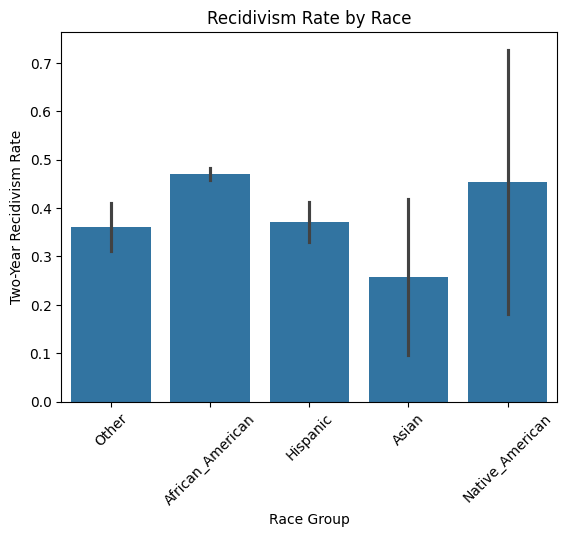

In [22]:
sns.barplot(x="Race_Group", y="Two_yr_Recidivism", data=df)
plt.title("Recidivism Rate by Race")
plt.xlabel("Race Group")
plt.xticks(rotation=45)
plt.ylabel("Two-Year Recidivism Rate")
save_plot("barplot_recidivism_by_race.png")
plt.show()

In [23]:
# Test if recidivism differs significantly by race
contingency_race = pd.crosstab(df['Race_Group'], df['Two_yr_Recidivism'])
chi2, p_value, dof, expected = chi2_contingency(contingency_race)
print(f"Race vs Recidivism: Chi2={chi2:.3f}, p-value={p_value:.3f}")

Race vs Recidivism: Chi2=36.385, p-value=0.000


#### 3.6.2 Recividism rates across all demographic combinations

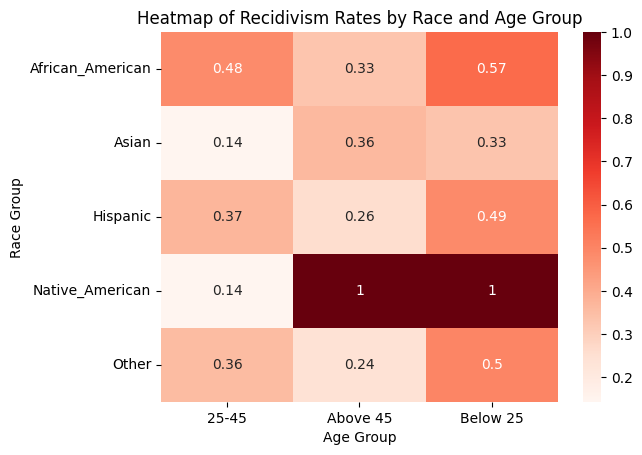

In [24]:
# Heatmap of recidivism rates across all demographic combinations
pivot_table = df.pivot_table(values='Two_yr_Recidivism', 
                            index='Race_Group', 
                            columns='Age_Group', 
                            aggfunc='mean')
sns.heatmap(pivot_table, annot=True, cmap='Reds')
plt.title("Heatmap of Recidivism Rates by Race and Age Group")
plt.xlabel("Age Group")
plt.ylabel("Race Group")
save_plot("heatmap_recidivism_demographics.png")

In [25]:
# This is crucial for bias detection - are priors distributed fairly?
df.groupby('Race_Group')['Number_of_Priors'].describe()

,count,mean,std,min,25%,50%,75%,max
Race_Group,,,,,,,,
African_American,5278.0,3.461538,4.875903,0.0,0.0,2.0,5.0,38.0
Asian,31.0,1.354839,2.244228,0.0,0.0,0.0,2.0,9.0
Hispanic,509.0,2.100196,3.695041,0.0,0.0,1.0,2.0,26.0
Native_American,11.0,5.181818,7.110811,0.0,0.5,2.0,6.0,22.0
Other,343.0,1.746356,3.411767,0.0,0.0,0.0,2.0,31.0


In [26]:
# Compare actual recidivism rates vs. what we'd expect by chance
overall_rate = df['Two_yr_Recidivism'].mean()
print(f"Overall recidivism rate: {overall_rate:.3f}")

Overall recidivism rate: 0.455


## 4. Modeling

### 4.1 Train/Test Split

In [27]:
X = df.drop(columns=["Two_yr_Recidivism"])
y = df["Two_yr_Recidivism"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train Size:", X_train.shape)
print("Test Size:", X_test.shape)

Train Size: (4320, 13)
Test Size: (1852, 13)


### 4.2 Logistic Regression

In [28]:
feature_cols = [
    'Number_of_Priors',
    'score_factor',
    'Age_Above_FourtyFive',
    'Age_Below_TwentyFive',
    'African_American',
    'Asian',
    'Hispanic',
    'Native_American',
    'Other',
    'Female',
    'Misdemeanor'
]

X = df[feature_cols]
y = df["Two_yr_Recidivism"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

Logistic Regression
Accuracy: 0.6825053995680346

Confusion Matrix:
 [[784 225]
 [363 480]]

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.78      0.73      1009
           1       0.68      0.57      0.62       843

    accuracy                           0.68      1852
   macro avg       0.68      0.67      0.67      1852
weighted avg       0.68      0.68      0.68      1852



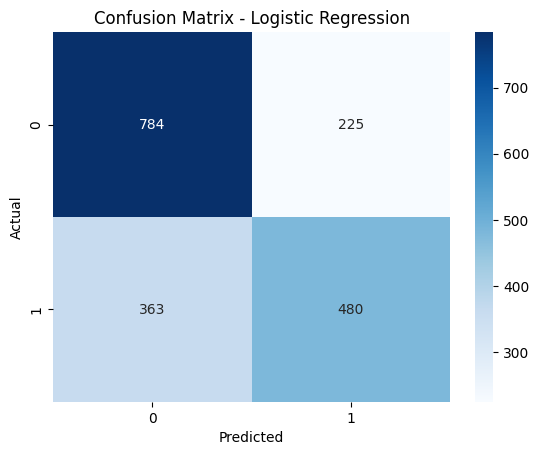

In [29]:
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

### 4.3 Decision Tree

In [30]:
tree = DecisionTreeClassifier(random_state=42, max_depth=5)

# Training
tree.fit(X_train, y_train)

# Predictions
y_pred_tree = tree.predict(X_test)

# Evaluation
print("Decision Tree")
print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_tree))
print("\nClassification Report:\n", classification_report(y_test, y_pred_tree))

Decision Tree
Accuracy: 0.677645788336933

Confusion Matrix:
 [[765 244]
 [353 490]]

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.76      0.72      1009
           1       0.67      0.58      0.62       843

    accuracy                           0.68      1852
   macro avg       0.68      0.67      0.67      1852
weighted avg       0.68      0.68      0.67      1852



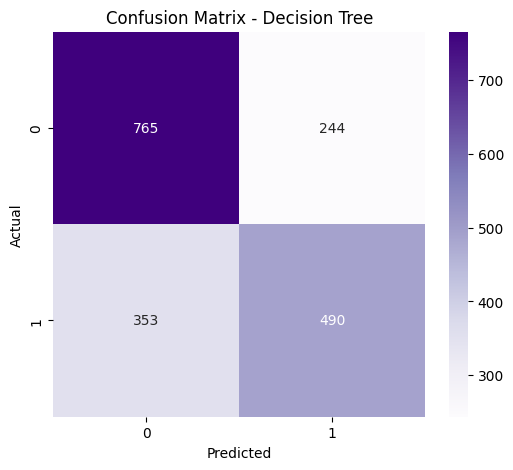

In [31]:
cm_tree = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_tree, annot=True, fmt="d", cmap="Purples", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Decision Tree")
save_plot("confusion_matrix_tree.png")
plt.show()

## 5. Fairness & Bias Evaluation

### 5.1 Helper Function for Group Metrics

In [32]:
def evaluate_by_group(model, X_test, y_test, group_feature, df):
    """
    Evaluate performance metrics for each value of a sensitive feature (e.g., gender, race).

    Args:
        model (sklearn.base.BaseEstimator): The trained model to evaluate.
        X_test (pd.DataFrame): The test features.
        y_test (pd.Series): The true labels for the test set.
        group_feature (str): The name of the sensitive feature to evaluate by.
        df (pd.DataFrame): The original DataFrame containing the sensitive feature.

    Returns:
        pd.DataFrame: A DataFrame containing the evaluation results.
    """
    results = []

    # Predictions
    y_pred = model.predict(X_test)

    # Create dataframe with true labels, predicted labels, and sensitive group
    eval_df = pd.DataFrame({
        "y_true": y_test.values,
        "y_pred": y_pred
    }, index=X_test.index)
    eval_df[group_feature] = df.loc[X_test.index, group_feature]

    # Global metrics
    global_metrics = {
        "Group": "Global",
        "Accuracy": accuracy_score(eval_df["y_true"], eval_df["y_pred"]),
        "Precision": precision_score(eval_df["y_true"], eval_df["y_pred"], zero_division=0),
        "Recall": recall_score(eval_df["y_true"], eval_df["y_pred"], zero_division=0),
        "F1": f1_score(eval_df["y_true"], eval_df["y_pred"], zero_division=0)
    }
    results.append(global_metrics)

    # Metrics per subgroup
    for g, subset in eval_df.groupby(group_feature):
        group_metrics = {
            "Group": f"{group_feature}={g}",
            "Accuracy": accuracy_score(subset["y_true"], subset["y_pred"]),
            "Precision": precision_score(subset["y_true"], subset["y_pred"], zero_division=0),
            "Recall": recall_score(subset["y_true"], subset["y_pred"], zero_division=0),
            "F1": f1_score(subset["y_true"], subset["y_pred"], zero_division=0)
        }
        results.append(group_metrics)

    return pd.DataFrame(results)

### 5.2 Evaluation by Gender

In [33]:
# Bias evaluation by Gender
results_gender = evaluate_by_group(log_reg, X_test, y_test, "Female", df)
print("Bias Evaluation by Gender")
display(results_gender)

Bias Evaluation by Gender


,Group,Accuracy,Precision,Recall,F1
0,Global,0.682505,0.680851,0.569395,0.620155
1,Female=0,0.673592,0.680885,0.601955,0.638992
2,Female=1,0.719444,0.680556,0.385827,0.492462


### 5.3 Evaluation by Age Group

In [34]:
# Create Age Group column in the test set
df["Age_Group"] = df.apply(lambda row: 
                           "Below 25" if row["Age_Below_TwentyFive"] == 1 
                           else ("Above 45" if row["Age_Above_FourtyFive"] == 1 else "25-45"), axis=1)

# Bias evaluation by Age
results_age = evaluate_by_group(log_reg, X_test, y_test, "Age_Group", df)
print("Bias Evaluation by Age")
display(results_age)

Bias Evaluation by Age


,Group,Accuracy,Precision,Recall,F1
0,Global,0.682505,0.680851,0.569395,0.620155
1,Age_Group=25-45,0.665044,0.680739,0.536383,0.600000
2,Age_Group=Above 45,0.751861,0.662162,0.395161,0.494949
3,Age_Group=Below 25,0.658768,0.686508,0.726891,0.706122


### 5.4 Evaluation by Race

In [35]:
# Create Race Group column
def race_group(row):
    """
    Get the race group for a given row.

    Args:
        row (pd.Series): A row from the DataFrame.

    Returns:
        str: The race group label.
    """
    if row["African_American"] == 1: return "African_American"
    if row["Hispanic"] == 1: return "Hispanic"
    if row["Asian"] == 1: return "Asian"
    if row["Native_American"] == 1: return "Native_American"
    return "Other"

df["Race_Group"] = df.apply(race_group, axis=1)

# Bias evaluation by Race
results_race = evaluate_by_group(log_reg, X_test, y_test, "Race_Group", df)
print("Bias Evaluation by Race")
display(results_race)

Bias Evaluation by Race


,Group,Accuracy,Precision,Recall,F1
0,Global,0.682505,0.680851,0.569395,0.620155
1,Race_Group=African_American,0.675732,0.702213,0.682975,0.692460
2,Race_Group=Asian,0.727273,0.000000,0.000000,0.000000
3,Race_Group=Hispanic,0.680851,0.727273,0.400000,0.516129
4,Race_Group=Native_American,0.500000,0.000000,0.000000,0.000000
5,Race_Group=Other,0.691375,0.614943,0.397770,0.483070


In [36]:
# Decision Tree evaluation by Race
results_race_tree = evaluate_by_group(tree, X_test, y_test, "Race_Group", df)

print("Decision Tree - Bias Evaluation by Race")
display(results_race_tree)

Decision Tree - Bias Evaluation by Race


,Group,Accuracy,Precision,Recall,F1
0,Global,0.677646,0.667575,0.581257,0.621433
1,Race_Group=African_American,0.662134,0.691837,0.663405,0.677323
2,Race_Group=Asian,0.909091,1.000000,0.666667,0.800000
3,Race_Group=Hispanic,0.652482,0.627907,0.450000,0.524272
4,Race_Group=Native_American,0.500000,0.000000,0.000000,0.000000
5,Race_Group=Other,0.699461,0.616162,0.453532,0.522484
